In [1]:
import os
# from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib.colors import BoundaryNorm, LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.ticker import MaxNLocator
import pandas as pd
import datetime
from mpl_toolkits.mplot3d import Axes3D, axes3d

# import pandas as pd
import xarray as xr
from scipy import signal, integrate

import xrft.xrft as xrft
import subroutines
import importlib
plt.style.use('latex_default_0.mplstyle')

In [2]:
compSetting = 'translbq3D_settings' # 'translbq3D_shape' , 'translbq3D_atm'
# compSetting = 'translbq3D_shape' 
# compSetting = 'translbq3D_wind' 
# compSetting = 'translbq3D_atm' 

folder_path = '/work/bd0620/b309199/translbq3D/'

# compSetting = 'translbq3D_settings' # 'translbq3D_shape' , 'translbq3D_atm'
# compSetting = 'translbq3D_shape' 
# compSetting = 'translbq3D_windPrezi' 
compSetting = 'translbq3D_wind' 
# compSetting = 'translbq3D_ctopo' 
# compSetting = 'translbq3D_atm' 

######################################## 
if compSetting == 'translbq3D_shape':
    fileLocations = ['translbq3D_002', 'translbq3D_004','translbq3D_005','translbq3D_006']
    labels=['L: 300$\,$km, H: 750$\,$m', 'L: 200$\,$km, H: 750$\,$m', 'L: 400$\,$km, H: 750$\,$m', 'L: 300$\,$km, H: 1000$\,$m']
    
if compSetting == 'translbq3D_atm':
# Compare stability and coriolis
    fileLocations = ['translbq3D_002', 'translbq3D_010', 'translbq3D_011', 'translbq3D_012']
    labels=['N: 0.02$\, \mathrm{s}^{-1}$, f: -55°S-', 'N: 0.015$\, \mathrm{s}^{-1}$, f: -55°S-', 'N: 0.02$\, \mathrm{s}^{-1}$, f: -45°S-', r'$c_{tf}$: $0 \, \mathrm{m} \, \mathrm{s}^{-1}$']
    
if compSetting == 'translbq3D_wind':
    fileLocations = ['translbq3D_002', 'translbq3D_001', 'translbq3D_003', 'translbq3D_007', 'translbq3D_008', 'translbq3D_009']
    labels=['PNJ: 80$ \, \mathrm{m} \, \mathrm{s}^{-1}$', 'PNJ: 60$ \, \mathrm{m} \, \mathrm{s}^{-1}$', 'PNJ: 100$ \, \mathrm{m} \, \mathrm{s}^{-1}$', 'TPJ: 55$ \, \mathrm{m} \, \mathrm{s}^{-1}$','W/o "valve layer"','Summer sc.']

if compSetting == 'translbq3D_ctopo':
# ---- Constant wind -------- #
    fileLocations = ['translbq3D_015', 'translbq3D_014', 'translbq3D_016']
    labels = [r'$c_{tf}$: $0 \, \mathrm{m} \, \mathrm{s}^{-1}$',r'$c_{tf}$: $13.88 \, \mathrm{m} \, \mathrm{s}^{-1}$', r'$c_{tf}$: $27.76 \, \mathrm{m} \, \mathrm{s}^{-1}$'] #r'$c_{tf}$: $0 \, \mathrm{m} \, \mathrm{s}^{-1}$'
    
if compSetting == 'translbq3D_windPrezi':
    fileLocations = ['translbq3D_002', 'translbq3D_003', 'translbq3D_007', 'translbq3D_008']
    labels=['PNJ: 80m s$^{-1}$', 'PNJ: 100m s$^{-1}$', 'TropJet: 55m s$^{-1}$','w/o "valve layer"']
########################################    
# if compSetting == 'translq3D_settings':
#     fileLocations = ['translbq3D_002a', 'translbq3D_002a','translbq3D_002c','translbq3D_002d','translbq3D_012']
#     # fileLocations = ['/scratch/b/b309199/translbq3D_002a', '/scratch/b/b309199/translbq3D_002e']
#     labels=['normal', 'dx=12500', '1/2 dz', 'T=140K', 'statlb']
        
# if compSetting == 'translb_ctopo':
# Compare to transient width, stationary TD and high resolution run
#     fileLocations = ['../translb_002_cyclic', '../translb_013a', '../translb_015']
#     labels=['PNJ: 80m/s (Ref)', 'statlb (u-ctopo)', 'ctopo: 27.7m/s']

ds_list = []
for fileLocation in fileLocations:
    fileLocation = folder_path + fileLocation
    env_fileName = "env.nc"
    tapes_fileName = "tapes.nc" # "tapes.nc"
    grid_fileName = "grd.nc"
    env_path = os.path.join(fileLocation, env_fileName)
    tapes_path = os.path.join(fileLocation, tapes_fileName)
    grid_path = os.path.join(fileLocation, grid_fileName)

    ds = xr.open_dataset(tapes_path) #, decode_times=False)
    # DS['alt_plot'] = (DS.altitude + DS.altitude_offset + DS.station_height) / 1000 #km
    # DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature) # Change 0 to NaN

    ds_grid = xr.open_dataset(grid_path)
    ds_env = xr.open_dataset(env_path)

    if len(ds.w.shape) == 3: # 2D case
        # ds_env['time'] = ds['time']
        ds = ds.drop('time')
        ds['ELEVATION'] = ds['ELEVATION'].expand_dims({'t':ds.t})
        # ds = ds.drop('ELEVATION')
        ds = ds.expand_dims('y',axis=2)

    if len(ds_env.ue.shape) == 3: # not time depedant case
        ds_env = ds_env.expand_dims({'t':ds.t})

    ds = ds.assign_coords({'xcr':ds_grid['xcr']/1000, 'zcr':ds_env['zcr']/1000, 'ycr':ds_grid['ycr']/1000,
                          'zs':ds_grid['zs']/1000, 'zh':ds_grid['zh']/1000, 'gi':ds_grid['gi']})
    ds_env = ds_env.drop('zcr')
    ds = ds.merge(ds_env)

    # ---- Sim parameters -------------- # 
    ds.attrs = ds_grid.attrs
    ds.attrs['bv'] = ds.attrs['bv']
    ds.attrs['u00'] = ds['ue'][0,0,0,0].values
    ds.attrs['v00'] = ds['ve'][0,0,0,0].values
    ds.attrs['nx'] = np.shape(ds['w'])[3]
    ds.attrs['ny'] = np.shape(ds['w'])[2]
    ds.attrs['nz'] = np.shape(ds['w'])[1]
    
    ds = subroutines.dzdx_topo(ds)
    # ---- Sim parameters -------------- # 

    # ---- Constants ------------------- #
    pref00=101325.
    # pref00=23700.
    ds.attrs['cp']=3.5*ds.rg # Earth
    # ds.attrs['cp']=24.4/2*ds.rg # consistent with simulation
    ds.attrs['grav']=ds.g
    ds.attrs['cap']=ds.rg/ds.cp
    ds.attrs['capi'] =1/ds.cap
    ds.attrs['capp']=1-ds.cap # Cv/Cp
    ds.attrs['cappi']=1/ds.capp   # Cp/Cv
    ds.attrs['compri']=ds.rg/pref00**ds.cap
    # ---- Constants ------------------- # 

    # ---- IDL code of AD -------------- # 
    # Forces (MF_x, EF_z, EF_x)
    # h1: ttt (theta)
    # h2: tloc-tte with tloc = thloc*(ploc/pref00)^cap
    # h3: wprime = w
    # h4: tprime+the
    # h5: sqrt(uprime^2+vprime^2)
    # h6: uprime
    # h7: ploc or h12-h12(100), h12=p
    # h9: MFx
    # h11: EFx
    # h12: pprime filtered
    # ---- IDL code of AD -------------- #

    # ---- Perturbations -- #
    # Uncomment line that suits available data
    # ds['uprime'] = ds['u'] - ds['u'][:,:,:,0] # time-dependant background state
    # ds['uprime'] = ds['u'] - ds['ue']

    # ds['vprime'] = ds['v'] - ds['ve'][:,:,:,0] # time-dependant background state
    # ds['vprime'] = ds['v'] - ds['ve']

    # ds['wprime'] = ds['w']
    
    # ---- Pressure ------- #
    ds['pref00'] = ds['pr0'].max() # Pa pref00=101325.
    # p is pressure perturbation output from EULAG
    # h12 is 2D filtered
    # h7 additionally referenced to x-location before mtn
    # ppe=(rhe*the*compri)^cappi
    ds['pprime']=ds['p'] # h12
    # ds['pprime']=subroutines.filt_2dx(ds['p'],1) # h12
    # ds['pprime']=filt_2dx(ds['p'],0) # h12
    # ds['ploc'] = ds['pprime'] + ds['pr0']
    # ds['h7'] = ds['pprime'] - ds['pprime'][:,:,:,100] # x=100 before mtn?

    ds_cp = ds.copy()
    ds_list.append(ds_cp)

0
[10.460518    8.150017    5.986866    4.428295    3.3118172   3.4312363
  4.122879    4.2850227   4.5588455   4.511551    4.4668427   4.2851486
  4.0473137   3.7911644   3.4669838   3.345829    3.6338081   3.654705
  3.7861977   3.7120285   3.6205482   3.4443588   3.3120346   3.293789
  3.417694    3.311329    3.2405434   3.0554276   2.7695732   2.5349998
  2.6315575   2.7002563   2.9407501   2.9425392   3.0910034   3.016018
  3.047165    2.91214     2.8518448   2.6542282   2.5296288   2.298542
  2.1862946   2.1723175   2.316227    2.2612877   2.3845062   2.3100967
  2.3946419   2.2891655   2.3423195   2.2091827   2.2324638   2.087082
  2.0674973   1.9112625   1.8481522   1.6676369   1.7093315   1.6885452
  1.8054771   1.7830315   1.8932915   1.9348259   2.0902672   2.111267
  2.2404633   2.245823    2.3675766   2.3633194   2.4814835   2.489563
  2.636631    2.6772652   2.8325386   2.8509598   2.964035    2.9332962
  3.0042877   2.9307709   2.9851494   2.9158325   2.971672    2.93383

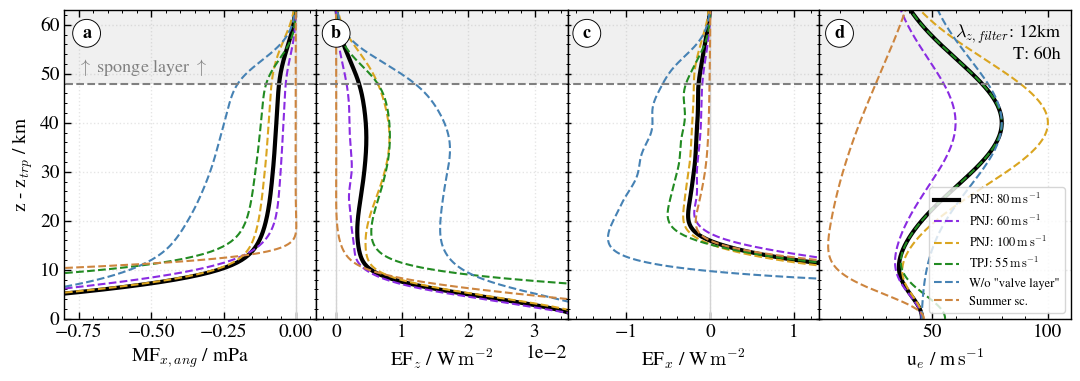

In [4]:
importlib.reload(subroutines)
plt.style.use('latex_default_0.mplstyle')
gskw = {'wspace':0}
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(11,4),sharey=True, gridspec_kw=gskw)

# --- SET TIME, Y AND VERTICAL AEQUIDISTANT GRID --- #
# x=480+53 # t=4 -> 400km (dx=7500m) // 
# x=480 # t=3
# x_range = 20 # -> mean over width of 300km
t=5 # t=3 -> 36h
# COLS=['darkblue','slateblue','darkviolet', 'mediumorchid', 'lightcoral','tomato', 'firebrick', 'black']
COLS=['black', 'blueviolet', 'goldenrod', 'forestgreen', 'steelblue', 'peru', 'olive', 'firebrick']
# COLS=['blueviolet', 'black', 'goldenrod', 'forestgreen', 'steelblue', 'peru', 'olive', 'firebrick']
ZLIM = [0,63]

# --- INDEXES FOR VERTICAL AND HORIZONTAL AVERAGE --- #
wind_f = 31.1 # m/s
# nx_avg = int(2*np.pi*(ds['ue'][0,0,0,0]-50/3.6)/ds.bv/ds.dx00)+1
# nz_avg = int(2*np.pi*(ds['ue'][0,0,0,0]-50/3.6)/ds.bv/ds.dz00)+1
nx_avg = int(2*np.pi*wind_f/ds.bv/ds.dx00)+1
nz_avg = int(2*np.pi*wind_f/ds.bv/ds.dz00)+1
nz_avg = 48 # *0.25km -> 12km

symb_ax = '-'
col_ax = 'lightgrey'
lw_ax = 1
ax0.hlines(y=0, xmin=-20, xmax=200, lw=lw_ax,ls=symb_ax,color=col_ax)
ax1.hlines(y=0, xmin=-20, xmax=200, lw=lw_ax,ls=symb_ax,color=col_ax)
ax2.hlines(y=0, xmin=-20, xmax=200, lw=lw_ax,ls=symb_ax,color=col_ax)
ax3.hlines(y=0, xmin=-20, xmax=200, lw=lw_ax,ls=symb_ax,color=col_ax)

ax0.vlines(x=0, ymin=-10, ymax=100, lw=lw_ax,ls=symb_ax,color=col_ax)
ax1.vlines(x=0, ymin=-10, ymax=100, lw=lw_ax,ls=symb_ax,color=col_ax)
ax2.vlines(x=0, ymin=-10, ymax=100, lw=lw_ax,ls=symb_ax,color=col_ax)
ax3.vlines(x=0, ymin=-10, ymax=100, lw=lw_ax,ls=symb_ax,color=col_ax)

i=0
for ds_temp in ds_list:
    ds = ds_temp.copy()
    print(i)
    
    y=int(ds.ny/2)
    z = np.linspace(0,ds['zcr'][t,-1,y,0].values,int(ds.nz)) # ds['dx']=200
    
    # - Coriolis and dthdz for angular momentum flux calculation - #
    f = ds.fcr0 * np.sin(ds.ang*np.pi/180)
    
    z_coord = np.linspace(0,ds.zcr[0,-1,0,0],ds.nz)*1000
    the = ds['the'][t,:,y,:]
    the = the.assign_coords(z_coord = ("z",z_coord))
    dthdz = the.differentiate("z_coord")
    
    # --------- Calculate fluxes -------------------- # 
    uw   = ds['w'][t,:,y,:] * (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:])
    vw   = ds['w'][t,:,y,:] * (ds['v'][t,:,y,:]-ds['ve'][t,:,y,:])
    mfx  = ds['rh0'][t,:,y,:] * uw # h9=h3*h6
    mfx_ang = ds['rh0'][t,:,y,:] * (uw - f * (ds['v'][t,:,y,:]-ds['ve'][t,:,y,:]) * ds['th'][t,:,y,:] / dthdz) ###########
    mfy  = ds['rh0'][t,:,y,:] * vw
    mfy_ang = ds['rh0'][t,:,y,:] * (vw + f * (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:]) * ds['th'][t,:,y,:] / dthdz)
    MF_U = mfx * ds['ue'][t,:,y,:] + mfy * ds['ve'][t,:,y,:] # = -EFz
    MF_U_ang = mfx_ang * ds['ue'][t,:,y,:] + mfy_ang * ds['ve'][t,:,y,:]
    
    efx = (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:]) * ds['pprime'][t,:,y,:] # h14, EFx1
    efz = ds['w'][t,:,y,:] * ds['pprime'][t,:,y,:] # h13, EFz1

    # -- TEMPERATURE CALCULATION -- #                             
    thloc = ds['the'][t,:,y,:] + ds['th'][t,:,y,:] # Theta
    # ds['tloc'] = ds['thloc']*(ds['ploc']/ds['pref00'])**ds.cap
    tte = ds['the'][t,:,y,:]*(ds['pr0'][t,:,y,:]/ds['pref00'])**ds.cap # T_env
    # tte = ds['the'][t,:,y,:]*(ds['ppe'][t,:,y,:]/ds['pref00'])**(2/24.4) # T_env
    tloc = thloc*(ds['pr0'][t,:,y,:]/ds['pref00'])**ds.cap # T
    tprime = tloc-tte

    ep = 1/2*(ds.grav/ds.bv)**2 * (tprime/tte)**2 # * ds['rh0'][t,:,y,:] #  potential energy density
    # --------- Calculate fluxes -------------------- # 
    
    # --- INTERPOLATE TO AEQUIDISTANT GRID FOR FILTER ----- #
    ue    = subroutines.interp_elev_to_z(ds['ue'][t,:,y,:],ds.zcr[t,:,y,:],z)
    mfx  = subroutines.interp_elev_to_z(mfx,ds.zcr[t,:,y,:],z)
    mfx_ang  = subroutines.interp_elev_to_z(mfx_ang,ds.zcr[t,:,y,:],z)
    efx  = subroutines.interp_elev_to_z(efx,ds.zcr[t,:,y,:],z)
    efz  = subroutines.interp_elev_to_z(efz,ds.zcr[t,:,y,:],z)
    ep   = subroutines.interp_elev_to_z(ep,ds.zcr[t,:,y,:],z)
    MF_U = subroutines.interp_elev_to_z(MF_U,ds.zcr[t,:,y,:],z)
    MF_U_ang = subroutines.interp_elev_to_z(MF_U_ang,ds.zcr[t,:,y,:],z)
    
    # --- FFT OR RUNNING MEAN FILTER ------ #
    mm = 1
    
    # --- 1D filter --- #
    mfx = subroutines.filter_1Dz(mfx,nz_avg,mode=mm)
    mfx_ang = subroutines.filter_1Dz(mfx_ang,nz_avg,mode=mm)
    mfy = subroutines.filter_1Dz(mfy,nz_avg,mode=mm)
    ep  = subroutines.filter_1Dz(ep,nz_avg,mode=mm)
    efx = subroutines.filter_1Dz(efx,nz_avg,mode=mm)
    if i==1:
        efz = subroutines.filter_1Dz(efz,nz_avg,mode=mm,pad_mode="edge")
    else:
        efz = subroutines.filter_1Dz(efz,nz_avg,mode=mm)
    MF_U = subroutines.filter_1Dz(MF_U,nz_avg,mode=mm)
    MF_U_ang = subroutines.filter_1Dz(MF_U_ang,nz_avg,mode=mm)
    
    # - Calc fluxes after interpolations and averaging/filtering - #
    # mfx = rho*uw
    # mfy = rho*vw
    # MF_U = mfx*u + mfy*v
    MF_U_ang = mfx_ang*ue
    
    # --- Horizontal average / horizontal integration of fluxes --- #
    if ds.irelx: # sponge layer left/right active 
        n_sponge=int(ds.dxabL/ds.dx00)
    else: # cyclic boundaries
        n_sponge=0
    
    # -> horizontal mean
    mfx_m = mfx[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    mfx_ang_m = mfx_ang[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    ep_m = ep[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    efx_m = efx[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    efz_m = efz[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    MF_U_m = MF_U[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    MF_U_ang_m = MF_U_ang[:,n_sponge:ds.nx-n_sponge].mean(axis=1)

    # -- VISUALIZATION -- #
    if i==0:
        lw = 3
        ls = '-'
    else:
        lw = 1.5
        ls = '--'
    # ax0.plot(1000*mfx_m, z, lw=lw, color=COLS[i], label=labels[i])
    ax0.plot(1000*mfx_ang_m, z, lw=lw, ls=ls, color=COLS[i], label=labels[i])
    ax1.plot(efz_m, z, lw=lw, ls=ls, label=labels[i], color=COLS[i])
    # ax1.plot(MF_U_m, z, lw=lw, color=COLS[i])
    # ax1.plot(-MF_U_ang_m, z, lw=lw, ls='dashed', color=COLS[i])
    ax2.plot(efx_m, z, lw=lw, ls=ls, label=labels[i], color=COLS[i])
    # ax2.plot(ep_m, z, lw=lw, label=labels[i], color=COLS[i])
    ax3.plot(ds['ue'][t,:,y,0], ds.zcr[t,:,y,0], lw=lw, ls=ls, color=COLS[i], label=labels[i])
    
    if i==0:
        efz_old = efz_m
        mf_old = mfx_ang_m
    else:
        err = (efz_m-efz_old)/efz_old*100
        err = (mfx_ang_m-mf_old)/mf_old*100
        # print(err)
    print(np.max(ds["u"][t,:,y,:].values,axis=1)-ds["ue"][t,:,y,0].values)
    i+=1
    
# -- FORMAT AXES -- #
ax0.set_xlabel('MF$_{x,ang}$ / mPa')
# ax0.set_xlabel('MF$_x$ & MF$_{x,ang}$[--] / mPa')
# ax1.set_xlabel(r"MF$\cdot$U & EF$_z$ [$\cdot \cdot$] / W m$^{-2}$")
ax1.set_xlabel(r"EF$_z$ / W$ \, \mathrm{m}^{-2}$")
ax2.set_xlabel(r"EF$_x$ / W$ \, \mathrm{m}^{-2}$")
# ax2.set_xlabel('E$_P$ / J kg$^{-1}$')
ax3.set_xlabel(r"u$_e$ / m$\, \mathrm{s}^{-1}$")

ax0.yaxis.set_minor_locator(AutoMinorLocator())
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_minor_locator(AutoMinorLocator())

ax0.tick_params(axis="y", which='both', right=False)
ax1.tick_params(axis="y", which='both', direction="inout", right=False)
ax2.tick_params(axis="y", which='both', direction="inout", right=False)
ax3.tick_params(axis="y", which='both', direction="inout", right=False)

# - SPONGE LAYER - #
lw_sponge = 1.5
hsponge = 48
ax0.hlines(y=hsponge, xmin=-20, xmax=200, lw=lw_sponge,ls='--',color='grey')
ax1.hlines(y=hsponge, xmin=-20, xmax=200, lw=lw_sponge,ls='--',color='grey')
ax2.hlines(y=hsponge, xmin=-20, xmax=200, lw=lw_sponge,ls='--',color='grey')
ax3.hlines(y=hsponge, xmin=-20, xmax=200, lw=lw_sponge,ls='--',color='grey')

sponge_label = r'$\uparrow$ sponge layer $\uparrow$'
ax0.text(0.05, 0.8, sponge_label, transform=ax0.transAxes, color='grey')

c3 = 'lightgrey'
htop = 73
alpha_sponge = 0.33
# axes[i,j].axhline(y=48, lw=1.5,ls='--',color='grey')
ax0.fill_between(ax0.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)
ax1.fill_between(ax1.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)
ax2.fill_between(ax2.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)
ax3.fill_between(ax3.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)

# --- Labels and legend --- #
ax3.legend(loc='lower right', fontsize=9) # 'upper left'

ax0.set_ylim(ZLIM)
ax0.set_ylabel(r'z - z$_{trp}$ / km')

# --- Limits and Sci format --- #
ax0.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax1.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax2.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
# ax3.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))

ax0.set_xlim([-0.8,0.07]) # MFx
# ax0.set_xlim([-4.5,0.07]) # MFx
ax1.set_xlim([-0.003,0.035]) # EFz
# ax1.set_xlim([-0.025,0.025]) # EFz
# ax2.set_xlim([-0.5,16]) # Ep
ax2.set_xlim([-1.7,1.3]) # EFx
ax3.set_xlim([1,110])
ax0.set_ylim(ZLIM)

ax0.grid(visible=True)
ax1.grid(visible=True)
ax2.grid(visible=True)
ax3.grid(visible=True)

# --- Text --- #
ax0.text(0.07, 0.91, 'a', transform=ax0.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
ax1.text(0.06, 0.91, 'b', transform=ax1.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
ax2.text(0.06, 0.91, 'c', transform=ax2.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
ax3.text(0.06, 0.91, 'd', transform=ax3.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})

time_label = 'T: ' + str(t*12) + 'h'
ax3.text(0.96, 0.84, time_label, transform=ax3.transAxes, horizontalalignment='right')
filter_label = '$\lambda_{z,filter}$: ' + str(int(nz_avg*ds.dz00/1000)) + 'km'
ax3.text(0.96, 0.91, filter_label, transform=ax3.transAxes, horizontalalignment='right')

# --- Save figure --- #
fig_title = 'TD-zprofiles-' + compSetting + '-T60h' + '-avg' + '.png'
fig.tight_layout()
fig.savefig('../figures/' + fig_title, facecolor='w', edgecolor='w',
                format='png', dpi=300, bbox_inches='tight')